## Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/data/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
from keras import models
from keras import layers
from keras.layers import Conv2D , BatchNormalization , Dropout , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16, ResNet50, MobileNetV2
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from keras.utils import to_categorical

In [7]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from generations import get_pokemon_species_names

## Dataset Preparation

In [8]:
generations = [1, 2, 3, 4]
pokemons = []

for gen in generations:
    pokemons.extend(get_pokemon_species_names(gen))
    
pokemons = sorted(pokemons)

In [9]:
data_gen = ImageDataGenerator(validation_split=0.2, 
                             rotation_range=40, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             horizontal_flip=True, 
                             fill_mode='nearest')

In [75]:
import pickle
from tqdm import tqdm

dir = 'data/input/'
X_data = []
Y_data = []
test_set = {}
for pokemon in tqdm(pokemons):
    images = os.listdir(dir+pokemon)
    for image in images:
        
        img = cv2.imread(os.path.join(dir, pokemon, image))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not int(image.split('.')[0]): # if first image of pokemon, skip and save this as the default pic
            test_set[pokemon]=cv2.resize(img, (200,200))
        
    
        if img is not None:
            img = cv2.resize(img,(200,200))
            X_data.append(img)
            Y_data.append(pokemon)
            for i in range(10):
                aug_img = data_gen.random_transform(img)
                aug_img = cv2.resize(aug_img,(200,200))
                X_data.append(aug_img)
                Y_data.append(pokemon)

X_data = np.array(X_data).astype('float32')
Y_data = np.array(Y_data)

encoder = LabelEncoder()
Y_data = encoder.fit_transform(Y_data)
Y_data = to_categorical(Y_data)

with open('label_encoder.pkl', 'wb') as file:
    # Use pickle to serialize the object and save it to the file
    pickle.dump(encoder, file)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

100%|██████████| 493/493 [01:59<00:00,  4.12it/s]


## Models

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(layers.Dense(Y_train.shape[1], activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [78]:
base = ResNet50(weights='imagenet', include_top=False,input_shape=X_train.shape[1:])
for layer in base.layers:
    layer.trainable = False
    
    
model = Sequential()
model.add(base)
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(Y_train.shape[1], activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [115]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import  Model

# Create a simple model using the resizing layer
input_shape = (None, None, 3)  # Adjust the input shape as needed
inputs = keras.Input(shape=input_shape)


vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3)) # X_train.shape[1:]
vgg.trainable = False

# Scale Inputs
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

x = layers.Resizing(64, 64, interpolation="bilinear", crop_to_aspect_ratio=False)(inputs)
x = scale_layer(x)
x = vgg(x, training=False)
x = Flatten()(vgg.output)
x = layers.Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = layers.Dense(Y_train.shape[1], activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [19]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Create a simple model using the resizing layer
input_shape = (None, None, 3)  # Adjust the input shape as needed
inputs = Input(shape=input_shape)
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
vgg.trainable = False


x = layers.Resizing(64, 64, interpolation="bilinear", crop_to_aspect_ratio=False)(inputs)
x = scale_layer(x)
x = vgg(x, training=False)


x = Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

# Define the prediction layer
# Assuming Y_train is already defined elsewhere in your code
prediction = layers.Dense(Y_train.shape[1], activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

## Training

In [117]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=25, batch_size=200, validation_split=0.2, callbacks=[early_stopping])

evaluation = model.evaluate(X_test, Y_test)
print(evaluation)
evaluation = model.evaluate(X_train, Y_train)
print(evaluation)

Epoch 1/25
74/74 [==============================] - 152s 2s/step - loss: 5.0519 - accuracy: 0.1105 - val_loss: 2.8837 - val_accuracy: 0.3921
Epoch 2/25
74/74 [==============================] - 119s 2s/step - loss: 2.0918 - accuracy: 0.4873 - val_loss: 1.0075 - val_accuracy: 0.7521
Epoch 3/25
74/74 [==============================] - 120s 2s/step - loss: 0.9255 - accuracy: 0.7455 - val_loss: 0.5145 - val_accuracy: 0.8803
Epoch 4/25
74/74 [==============================] - 125s 2s/step - loss: 0.5310 - accuracy: 0.8493 - val_loss: 0.3400 - val_accuracy: 0.9161
Epoch 5/25
74/74 [==============================] - 119s 2s/step - loss: 0.3618 - accuracy: 0.8975 - val_loss: 0.2467 - val_accuracy: 0.9384
Epoch 6/25
74/74 [==============================] - 115s 2s/step - loss: 0.2516 - accuracy: 0.9282 - val_loss: 0.1987 - val_accuracy: 0.9500
Epoch 7/25
74/74 [==============================] - 125s 2s/step - loss: 0.1944 - accuracy: 0.9472 - val_loss: 0.1736 - val_accuracy: 0.9547
Epoch 8/25
74

MemoryError: Unable to allocate 18.5 GiB for an array with shape (18412, 300, 300, 3) and data type float32

#### For transfer learning

In [21]:
vgg.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetuned = model.fit(X_train, Y_train, epochs=1, validation_split=0.2)




350/350 [==============================] - 267s 752ms/step - loss: 0.5651 - accuracy: 0.8685 - val_loss: 0.2423 - val_accuracy: 0.9374


## Loading Model

In [24]:
save_model = True #ONLY SET TRUE IF YOU WANNA SAVE IT. Be careful about overwriting.

if save_model:
    model.save("models/VGG19-v2.keras")
    

In [20]:
model = models.load_model("models/VGG19-tuned.keras")

## Test Accuracy

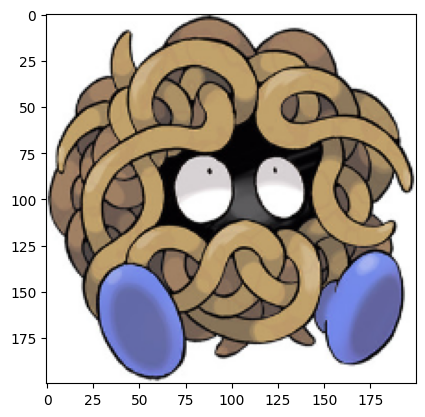

False
(1, 200, 200, 3)
1/1 [==============================] - 0s 188ms/step


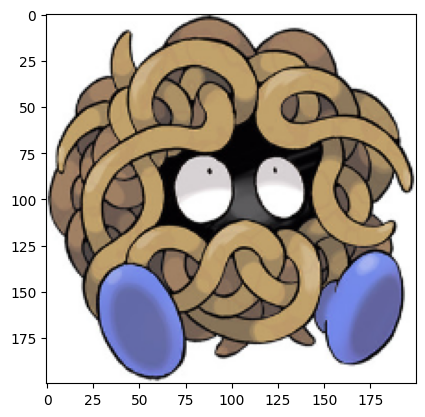

In [78]:
test_pokemon="Tangela"
plt.imshow(test_set[test_pokemon])
plt.show()

with open('dump.pkl', 'rb') as file:
    pic = pickle.load(file)  

print(np.all(test_set[test_pokemon]==pic))
print(np.expand_dims(test_set[test_pokemon], axis=0).shape)
prediction = model.predict(np.expand_dims(test_set[test_pokemon], axis=0));
plt.imshow(test_set[encoder.inverse_transform(np.argmax(prediction,axis=1))[0]])

In [13]:
test_pokemon="Rapidash"
img = np.expand_dims(test_set[test_pokemon], axis=0)
prediction = np.argmax(model.predict(img), axis=1)

with open('label_encoder.pkl', 'rb') as file:
    enc = pickle.load(file)   
    

enc.inverse_transform(prediction)

1/1 [==============================] - 0s 417ms/step


array(['Rapidash'], dtype='<U10')

In [23]:
correct = 0
for test_pokemon in pokemons:
    prediction = model.predict(np.expand_dims(test_set[test_pokemon], axis=0))
    if encoder.inverse_transform(np.argmax(prediction,axis=1))[0] == test_pokemon:
        correct +=1

print(correct/len(pokemons))


# plt.imshow(test_set[test_pokemon])
# plt.show()
# plt.imshow(test_set[encoder.inverse_transform(np.argmax(prediction,axis=1))[0]])

1/1 [==============================] - 0s 65ms/step
0.9188640973630832


In [30]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
import io

# URLs of the images
url_downloaded_image = '/data/input/Jynx/0.png'
url_online_image = 'https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/124.png'

# Load the downloaded image
downloaded_image = Image.open(url_downloaded_image)

# Send a GET request to the URL for the online image
response = requests.get(url_online_image)
online_image = Image.open(io.BytesIO(response.content))

# Display both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the downloaded image
axs[0].imshow(downloaded_image)
axs[0].set_title('Downloaded Image')
axs[0].axis('off')

# Display the online image
axs[1].imshow(online_image)
axs[1].set_title('Online Image')
axs[1].axis('off')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\data\\input\\Jynx\\0.png'

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


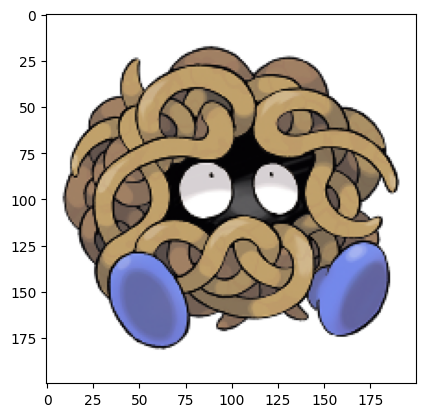

: 

In [79]:
import requests
from tensorflow.keras.preprocessing import image

img = requests.get("https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/114.png")
img = Image.open(io.BytesIO(response.content))
# Create a white background image
white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
img = Image.alpha_composite(white_bg, img)
img = img.convert("RGB")
img = np.array(img)
img = img[:, :, ::-1]
img = cv2.resize(img, (200,200))
print(img)
# print(img.shape)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

